# Intro

I'm trying to learn the very basics with this exercise. My goal is to train a linear regression model with a subset of columns from this interesting dataset in order to predict the value of a used car.

Any help or advice is welcome!!!

### Changelist

* removed feature regularization for Linear regression
* corrected Y values skewing
* added L2 regularized LR model
* added a neural net model
* added chart to visualize prediction samples

In [74]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib

# Preparing data

## Reading from file

Just reading the file and printing some lines.

In [75]:
df = pd.read_csv('autos.csv.gz', sep=',', header=0, compression='gzip',encoding='cp1252')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Cleaning data from outliers and dirty values

Cleaning data from duplicates, NaNs and selecting reasonable ranges for columns


In [76]:
# Cleaning data
valid_models = df.dropna()

#### Removing the duplicates
dedups = valid_models.drop_duplicates(['name','seller','offerType','price','abtest','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage','postalCode'])

#### Removing the outliers
no_outliers = dedups[(df.yearOfRegistration <=  2016) 
      & (df.yearOfRegistration >= 1950) 
      & (df.price >= 200) 
      & (df.price <= 50000) 
      & (df.powerPS >= 30) 
      & (df.powerPS <= 500) 
      & (df.kilometer >= 1000) 
      & (df.kilometer <= 300000)]

#rel_cols['price'].unique()
#rel_cols['yearOfRegistration'].unique()
#rel_cols['gearbox'].unique()
#rel_cols['powerPS'].unique()
#rel_cols['model'].unique()
#rel_cols['kilometer'].unique()
#rel_cols['monthOfRegistration'].unique()
#rel_cols['brand'].unique()
#rel_cols['notRepairedDamage'].unique()


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Selecting only relevant columns

Here I select the columns that I think are useful for determining a car's price.


In [77]:

# only relevant columns
rel_cols = no_outliers[['price'
                        ,'yearOfRegistration'
                        ,'gearbox'
                        ,'powerPS'
                        ,'model'
                        ,'kilometer'
                        ,'fuelType'
                        ,'vehicleType'
                        ,'monthOfRegistration'
                        ,'brand'
                        ,'notRepairedDamage']]
rel_cols.head()

,price,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,vehicleType,monthOfRegistration,brand,notRepairedDamage
3,1500,2001,manuell,75,golf,150000,benzin,kleinwagen,6,volkswagen,nein
4,3600,2008,manuell,69,fabia,90000,diesel,kleinwagen,7,skoda,nein
5,650,1995,manuell,102,3er,150000,benzin,limousine,10,bmw,ja
6,2200,2004,manuell,109,2_reihe,150000,benzin,cabrio,8,peugeot,nein
10,2000,2004,manuell,105,3_reihe,150000,benzin,limousine,12,mazda,nein


## Encoding

This part encodes the string fields to numerical values.

In [78]:
le_gearbox = preprocessing.LabelEncoder()
le_notRepairedDamage = preprocessing.LabelEncoder()
le_model = preprocessing.LabelEncoder()
le_brand = preprocessing.LabelEncoder()
le_fuelType = preprocessing.LabelEncoder()
le_vehicleType = preprocessing.LabelEncoder()

le_gearbox.fit(rel_cols['gearbox'])
tr = le_gearbox.transform(rel_cols['gearbox']) 
rel_cols.loc[:, 'gearbox_feat'] = pd.Series(tr, index=rel_cols.index)

le_notRepairedDamage.fit(rel_cols['notRepairedDamage'])
tr = le_notRepairedDamage.transform(rel_cols['notRepairedDamage']) 
rel_cols.loc[:, 'notRepairedDamage_feat'] = pd.Series(tr, index=rel_cols.index)

le_model.fit(rel_cols['model'])
tr = le_model.transform(rel_cols['model']) 
rel_cols.loc[:, 'model_feat'] = pd.Series(tr, index=rel_cols.index)

le_brand.fit(rel_cols['brand'])
tr = le_brand.transform(rel_cols['brand']) 
rel_cols.loc[:, 'brand_feat'] = pd.Series(tr, index=rel_cols.index)

le_fuelType.fit(rel_cols['fuelType'])
tr = le_fuelType.transform(rel_cols['fuelType']) 
rel_cols.loc[:, 'fuel_feat'] = pd.Series(tr, index=rel_cols.index)

le_vehicleType.fit(rel_cols['vehicleType'])
tr = le_vehicleType.transform(rel_cols['vehicleType']) 
rel_cols.loc[:, 'vehicle_feat'] = pd.Series(tr, index=rel_cols.index)

df_autos = rel_cols[ ['price'
                        ,'yearOfRegistration'
                        ,'gearbox_feat'
                        ,'powerPS'
                        ,'model_feat'
                        ,'fuel_feat'
                        ,'vehicle_feat'
                        ,'kilometer'
                        ,'monthOfRegistration'
                        ,'brand_feat'
                        ,'notRepairedDamage_feat']]

#autos_norm = normalizer.transform(autos)
autos = df_autos.values.astype(float) #scaler.transform(autos)

Y = autos[:,0]
X = autos[:,1:]

print(Y.shape)
print(X.shape)


/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(241445,)
(241445, 10)


## Correction

Transforming the right-skewed sale price column.

**TODO**: leave test w/ and w/o correction

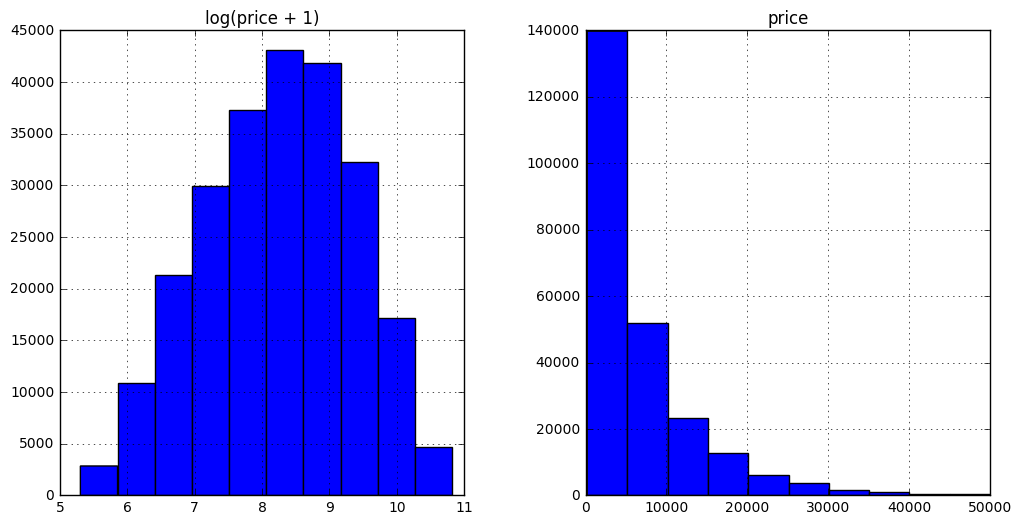

In [79]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":Y, "log(price + 1)":np.log1p(Y)})
prices.hist()

Y = np.log1p(Y)

# Trying out models

Trying with some model from scikit learn: LinearRegression, LR with L2 regularization and a Neural network.

In [80]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score


def cv_rmse(model, x, y):
    r = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return r



## Linear Regression

In [81]:
linear = linear_model.LinearRegression()

# Percent of the X array to use as training set. This implies that the rest will be test set
training_set_size = .9

train_len = int(X.shape[0] * training_set_size)
X_train = X[:train_len]
Y_train = Y[:train_len]

X_test = X[train_len+1:]
Y_test = Y[train_len+1:]

linear.fit(X_train,Y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear.score(X_test, Y_test))

cv_rmse(linear, X_train, Y_train).mean()


Variance score: 0.68


0.60818953224820371

# L2 regularized LR

Variance score: 0.68
Picked 10 variables and removed 0 variables
gearbox_feat             -0.069052
vehicle_feat             -0.039007
model_feat               -0.000202
kilometer                -0.000008
brand_feat                0.002911
monthOfRegistration       0.004737
powerPS                   0.008520
yearOfRegistration        0.060676
fuel_feat                 0.143854
notRepairedDamage_feat    0.706191
dtype: float64


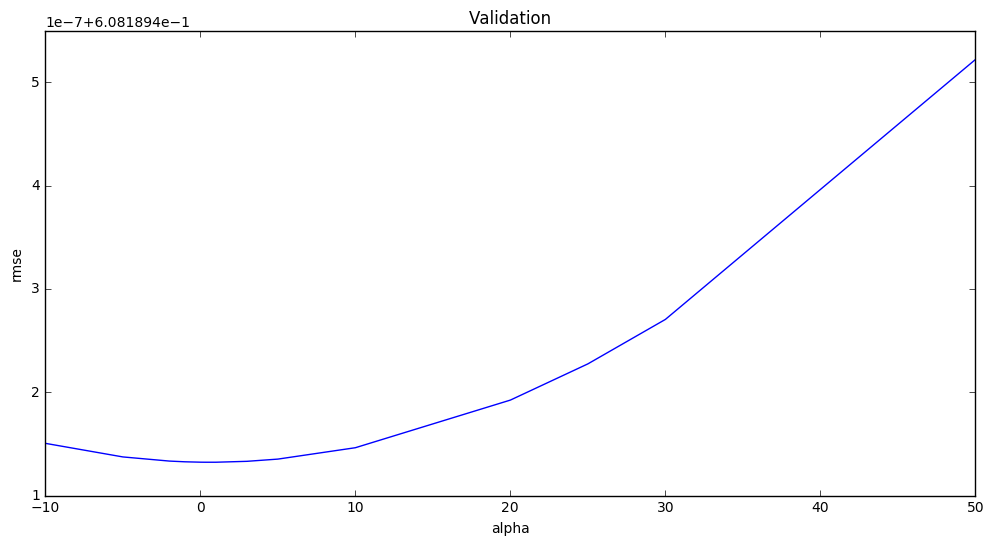

In [82]:

alphas = [-10, -5, -2, -1, 0, 0.005,0.05, 0.1, 0.3, 1, 3, 5, 10, 20, 25, 30, 50]
cv_ridge = [cv_rmse(Ridge(alpha = alpha), X_train, Y_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

model_ridge = Ridge(alpha = cv_ridge.min()).fit(X_train, Y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_ridge.score(X_test, Y_test))

coef = pd.Series(model_ridge.coef_, index = df_autos.iloc[:,1:].columns)

print("Picked " + str(sum(coef != 0)) + " variables and removed " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

## Testing with a neural net


In [83]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Splitting training and validation set
X_tr, X_val, y_tr, y_val = train_test_split(X, Y, random_state = 3)
print("Training set: ", X_tr.shape)
print("Validation set: ", X_val.shape)

# Scaling features
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = StandardScaler().fit_transform(X_val)


Training set:  (181083, 10)
Validation set:  (60362, 10)


In [84]:
# Preparing model
model = Sequential()
model.add(Dense(128, input_dim = X_tr.shape[1], W_regularizer=l1(0.001)))
model.add(Dense(16,  W_regularizer=l1(0.001)))
model.add(Dense(1,  W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

model.summary()

# Fitting...
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val), nb_epoch=10)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 128)           1408        dense_input_3[0][0]              
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 16)            2064        dense_7[0][0]                    
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 1)             17          dense_8[0][0]                    
Total params: 3,489
Trainable params: 3,489
Non-trainable params: 0
____________________________________________________________________________________________________
Train on 181083 samples, validate on 60362 samples
Epoch 1/10
181083/181083 [==============================] - 6s - loss: 1.

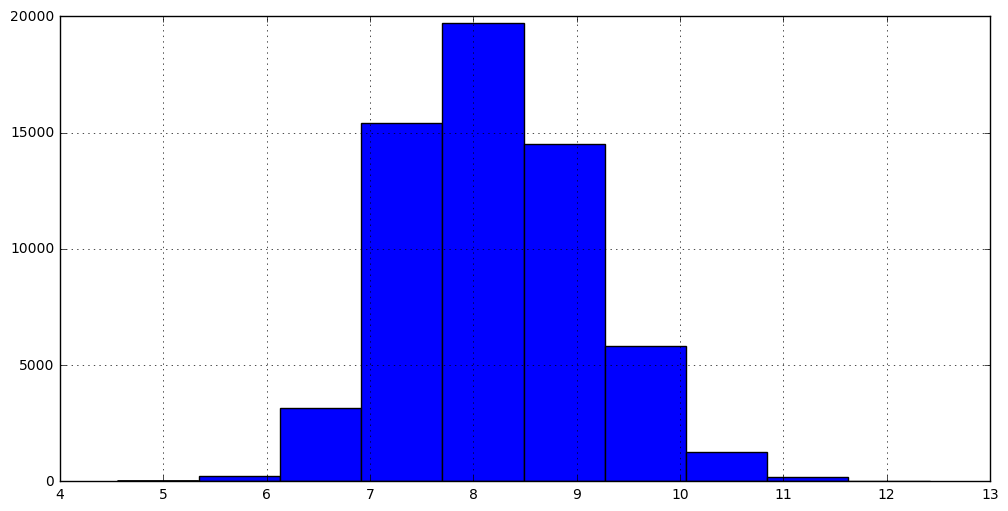

In [85]:
# Printing predictions on the validation set
pd.Series((model.predict(X_val)[:,0]) ).hist()
#pd.Series(np.expm1(model.predict(X_val)[:,0]) ).hist()

# Trying some prediction

In [86]:
# Fields:
#                        ,'yearOfRegistration'
#                        ,'gearbox_feat'
#                        ,'powerPS'
#                        ,'model_feat'
#                        ,'fuel_feat'
#                        ,'vehicle_feat'
#                        ,'kilometer'
#                        ,'monthOfRegistration'
#                        ,'brand_feat'
#                        ,'notRepairedDamage_feat'

year = 2016
gearbox = 'manuell'
powerPS = 115
car_model = 'touran'
fuel = 'benzin'
vehicle = 'bus'
km = 10000
reg_month = 1
brand = 'volkswagen'
not_repaired_damage = 'nein'

sample = [year
          , le_gearbox.transform([gearbox])
          , powerPS
          , le_model.transform([car_model])
          , le_fuelType.transform([fuel])
          , le_vehicleType.transform([vehicle])
          , km
          , reg_month
          , le_brand.transform([brand])
          , le_notRepairedDamage.transform([not_repaired_damage])]

# Scaling sample to feature's scale
sample = scaler.transform([sample])
s_predict = np.expm1(model.predict(sample))

print("This %d's %s %s is supposed to cost € %d in the used market." % (year , brand, car_model, s_predict))


This 2016's volkswagen touran is supposed to cost € 18885 in the used market.


## Plotting sample predictions on a chart

I'd like to plot how the car values changes over the years

1378 - 1568 - 927
25124 - 28583 - 16909


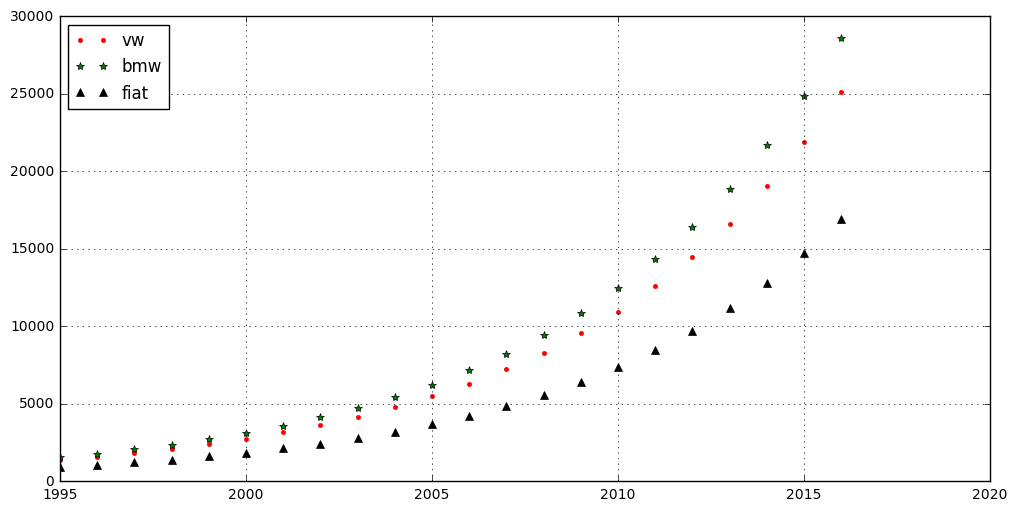

In [87]:
years = np.array(range(1995, 2017, 1))

def calc_values(brand, car_model, gearbox, fuel, powerPS):
    s = np.array([])
    for year in years:
        sample = [year
              , le_gearbox.transform([gearbox])
              , powerPS
              , le_model.transform([car_model])
              , le_fuelType.transform([fuel])
              , le_vehicleType.transform([vehicle])
              , 10000*(2017-year)
              , reg_month
              , le_brand.transform([brand])
              , le_notRepairedDamage.transform([not_repaired_damage])]
        sample = scaler.transform([sample])
        s_predict = np.expm1(model.predict(sample))
        s = np.append(s, s_predict[0][0])
    return s

vw = calc_values('volkswagen', 'touran', 'manuell', 'diesel', 115)
bmw  = calc_values('bmw', '3er', 'manuell', 'diesel', 150)
fiat  = calc_values('fiat', 'punto', 'manuell', 'diesel', 80)

print("%d - %d - %d" % (vw[0], bmw[0], fiat[0]))
print("%d - %d - %d" % (vw[-1], bmw[-1], fiat[-1]))

plt.plot(years, vw, 'r.', years ,bmw, 'g*', years, fiat, 'k^')
plt.legend(["vw", "bmw", 'fiat'], loc = 'upper left')
plt.grid(True)
